In [1]:
import argparse
import os
import logging
import sys
import itertools
import sys
import cv2
# sys.path.append("..") 
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from utils.misc import str2bool, Timer, freeze_net_layers, store_labels
from ssd.ssd import MatchPrior
from ssd.vgg_ssd import create_vgg_ssd,create_vgg_ssd_predictor
from ssd.mobilenetv1_ssd import create_mobilenetv1_ssd,create_mobilenetv1_ssd_predictor
from ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite,create_mobilenetv1_ssd_lite_predictor
from ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite,create_mobilenetv2_ssd_lite_predictor
from ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite,create_squeezenet_ssd_lite_predictor
from ssd.config import vgg_ssd_config
from ssd.config import mobilenetv1_ssd_config
from ssd.config import squeezenet_ssd_config
from ssd.data_preprocessing import TrainAugmentation, TestTransform
from data.voc_dataset import VOCDataset
# from data.open_images import OpenImagesDataset
from nn.multibox_loss import MultiboxLoss

In [73]:
########   https://github.com/qfgaohao/pytorch-ssd
net_type = 'mb2-ssd-lite'
model_path = './weights/mb2-ssd-lite-Epoch-575-Loss-1.1560787757237752.pth'
label_path = './weights/ego-models-labels.txt'
image_path = './egohands/JPEGImages/JENGA_COURTYARD_B_H_frame_0091.jpg'
# image_path = 't.jpg'

In [74]:
class_names = [name.strip() for name in open(label_path).readlines()]

if net_type == 'vgg16-ssd':
    net = create_vgg_ssd(len(class_names), is_test=True)
elif net_type == 'mb1-ssd':
    net = create_mobilenetv1_ssd(len(class_names), is_test=True)
elif net_type == 'mb1-ssd-lite':
    net = create_mobilenetv1_ssd_lite(len(class_names), is_test=True)
elif net_type == 'mb2-ssd-lite':
    net = create_mobilenetv2_ssd_lite(len(class_names), is_test=True,device=torch.device('cpu'))
elif net_type == 'sq-ssd-lite':
    net = create_squeezenet_ssd_lite(len(class_names), is_test=True)
else:
    print("The net type is wrong. It should be one of vgg16-ssd, mb1-ssd and mb1-ssd-lite.")
    sys.exit(1)
    

net.load(model_path)



if net_type == 'vgg16-ssd':
    predictor = create_vgg_ssd_predictor(net, candidate_size=200)
elif net_type == 'mb1-ssd':
    predictor = create_mobilenetv1_ssd_predictor(net, candidate_size=200)
elif net_type == 'mb1-ssd-lite':
    predictor = create_mobilenetv1_ssd_lite_predictor(net, candidate_size=200)
elif net_type == 'mb2-ssd-lite':
    predictor = create_mobilenetv2_ssd_lite_predictor(net, candidate_size=200)
elif net_type == 'sq-ssd-lite':
    predictor = create_squeezenet_ssd_lite_predictor(net, candidate_size=200)
else:
    predictor = create_vgg_ssd_predictor(net, candidate_size=200)

orig_image = cv2.imread(image_path)
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
boxes, labels, probs = predictor.predict(image, 10, 0.4)

for i in range(boxes.size(0)):
    box = boxes[i, :]
    print(box)
    cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 4)
    #label = f"""{voc_dataset.class_names[labels[i]]}: {probs[i]:.2f}"""
    label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
    cv2.putText(orig_image, label,
                (box[0] + 20, box[1] + 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                2,  # font scale
                (255, 0, 255),
                2)  # line type
path = "run_ssd_example_output.jpg"
cv2.imwrite(path, orig_image)
print(f"Found {len(probs)} objects. The output image is {path}")

Inference time:  0.09919857978820801
tensor([698.6005, 422.5078, 951.5484, 690.0314])
Found 1 objects. The output image is run_ssd_example_output.jpg


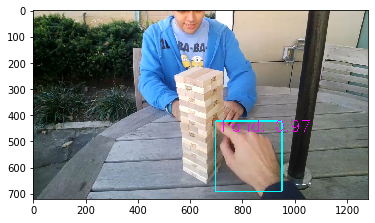

In [75]:
# 显示检测框体
import matplotlib.pyplot as plt
plt.imshow(orig_image[:,:,[2,1,0]])

tensor([[2.1208, 3.1767, 1.6227, 1.9426, 2.3912, 2.1317, 3.0538, 4.6713, 2.4992,
         1.6089]], device='cuda:0', grad_fn=<AsStridedBackward>) 7


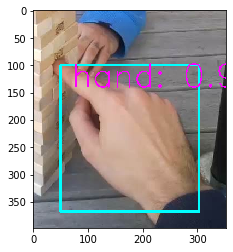

In [95]:
# 裁剪图片送入分类器
from PIL import Image
orig_image = orig_image[:,:,[2,1,0]]
if len(boxes)>0:
    np_boxes=boxes.numpy()
    box_1 = np_boxes[0]
    
    crop_image = orig_image[int(box_1[1])-100:int(box_1[3])+50,int(box_1[0])-50:int(box_1[2])+50,:]
    plt.imshow(crop_image)
    # 送入分类器图片必须是PIL 格式
    class_image = Image.fromarray(np.uint8(crop_image))
# cv2.imwrite('c.jpg',crop_image)
    from torchvision import transforms 
    import torch
    import random
    import os
    import os
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    device = torch.device("cuda: 0")
    trans=transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    model = torch.load('../../../classification/pth/sq_torch_1_0_color.pth')
#     row_image = Image.open('hand_gasture/crop_hand_gasture/val/B/user_10_crop_B5_crop.jpg')
    row_image= class_image
    device = torch.device("cuda: 0")
    image=trans(class_image)
    image = image.unsqueeze(0)
    # 直接转换图片，无法预测正确
    #             image = ((np.asarray(row_image)/255.0))#-np.array([0.485, 0.456, 0.406])/ np.array([0.229, 0.224, 0.225])
    #             image = np.resize(image, (224, 224, 3))
    #             image = np.expand_dims(np.transpose(image, axes=[2, 0, 1]), 0)

    pre = model(image.float().to(device))

    pre_index = np.argmax(pre.cpu().detach().numpy())
    print(pre,pre_index)

In [96]:
orig_image.shape

(720, 1280, 3)